In [546]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

In [547]:
%matplotlib inline

In [548]:
test=pd.read_csv("test.csv")
test.columns=['x','y']
feature_test=test['x']
x_test=feature_test.to_numpy()
x_test=x_test.reshape(x_test.size,1)
outputs_test=test[['y']]
y_test=outputs_test.to_numpy()
y_test=y_test.reshape(y_test.size,1)

In [549]:
train=pd.read_csv("train.csv")
train.columns=['x','y']
feature=train['x']
outputs=train[['y']]
y=outputs.to_numpy()
y=y.reshape(y.size,1)
x=feature.to_numpy()
x=x.reshape(x.size,1)

train.drop('y',axis=1,inplace=True)
for i in range(2,10):
    train[f'x{i}']=train['x']**i
train.insert(loc=0,column='x0',value=1)
train.rename(columns={'x':'x1'},inplace=True)
factor=(((train**2).sum(axis=0))/1000)**.5
train=train/factor

In [550]:
test.drop('y',axis=1,inplace=True)
for i in range(2,10):
    test[f'x{i}']=test['x']**i
test.insert(loc=0,column='x0',value=1)
test.rename(columns={'x':'x1'},inplace=True)
test=test/factor

In [551]:
lambdas=np.arange(.25,1.25,.25)
lambdas

array([0.25, 0.5 , 0.75, 1.  ])

### Coordinate Descent Algorithm for Lasso Regression

In [610]:
def coordinate_descent_lasso(train,outputs,lambdas):
    thetas=np.zeros((train.shape[1],lambdas.shape[0]))
    N=train.shape[0]
    for j in range(lambdas.shape[0]):
        lam=lambdas[j]
        theta=np.zeros((train.shape[1],1))
        while(1):
            max_step=-float('inf')
            for i in range(train.shape[1]):
                #print(f'theta[i] is {theta[i]}')
                prev_theta=theta[i][0]
                theta[i]=0
                h_theta=train@theta
                h_theta.columns=['y']
                difference=outputs-h_theta
                rho=train[f'x{i}'].T@difference
                if(i==0):
                    theta[0]=rho/1000
                    max_step=max(max_step,abs(theta[0]-prev_theta))
                    continue
                if((rho<-lam/2)[0]):
                    theta[i]=(rho+lam/2)/1000
                elif((rho>lam/2)[0]):
                    theta[i]=(rho-lam/2)/1000
                else:
                    theta[i]=0
                max_step=max(max_step,abs(theta[i]-prev_theta))
                #print(f'i is {i} and theta[i] is {theta[i]} prev_theta was{prev_theta}')
            if(max_step<.005):
                #print(max_step)
                break
        thetas[:,j:j+1]=theta
    return thetas

In [611]:
param1=coordinate_descent_lasso(train.iloc[:,:-1],outputs,lambdas)

In [612]:
param2=coordinate_descent_lasso(train.iloc[:,:2],outputs,lambdas)

In [613]:
param1

array([[ 0.42273162,  0.44525353,  0.46647927,  0.48607852],
       [ 2.17015245,  2.02288035,  1.89011962,  1.77069783],
       [-4.16650271, -3.93061536, -3.72111033, -3.5370987 ],
       [-0.65278814, -0.6521081 , -0.65126775, -0.64850198],
       [ 0.56760541,  0.44142881,  0.33130583,  0.23656259],
       [ 0.80163418,  0.77156792,  0.74281235,  0.71736768],
       [ 0.55496169,  0.55045899,  0.54464295,  0.53899403],
       [ 0.24487006,  0.26406883,  0.27967329,  0.29268693],
       [-0.01916609,  0.01199306,  0.04390945,  0.071204  ]])

In [614]:
def find_error(param,data,outputs):
    h_theta=data@param
    errors=(h_theta-outputs.to_numpy())**2
    return errors.sum(axis=0)/data.shape[0]

#### Train Errors

In [615]:
errors_lasso=np.zeros((param1.shape[1],4))
errors_lasso[:,0]=find_error(param1,train.iloc[:,:param1.shape[0]],outputs)
errors_lasso[:,1]=find_error(param2,train.iloc[:,:param2.shape[0]],outputs)

In [616]:
errors_lasso

array([[0.02801295, 0.19940908, 0.        , 0.        ],
       [0.03002676, 0.19941225, 0.        , 0.        ],
       [0.031909  , 0.19941554, 0.        , 0.        ],
       [0.03364985, 0.19941896, 0.        , 0.        ]])

#### Test Error

In [617]:
errors_lasso[:,2]=find_error(param1,test.iloc[:,:param1.shape[0]],outputs_test)
errors_lasso[:,3]=find_error(param2,test.iloc[:,:param2.shape[0]],outputs_test)

In [618]:
errors_lasso

array([[0.02801295, 0.19940908, 0.02939207, 0.19086765],
       [0.03002676, 0.19941225, 0.03154498, 0.19086126],
       [0.031909  , 0.19941554, 0.03356456, 0.19085498],
       [0.03364985, 0.19941896, 0.03543622, 0.19084882]])

For Plotting the Lasso Solution:

In [619]:

def process(x,n):
    x=x.copy()
    #print(x)
    for i in range(2,n):
        x[f'x{i}']=x['x']**i
        #print(x.head)
    x.insert(loc=0,column='x0',value=1)
    #print(x)
    x.rename(columns={'x':'x1'},inplace=True)
    x=x/factor.iloc[:n]
    #print(x)
    return x

x_plot=np.linspace(0,1,200);
x_plot=pd.DataFrame(data=x_plot,columns=['x'])
y_plot=np.zeros((x_plot.shape[0],2*param1.shape[1]))
x_processed=process(x_plot,10)
y_plot[:,:4]=x_processed.iloc[:,:-1]@param1
y_plot[:,4:]=x_processed.iloc[:,:2]@param2

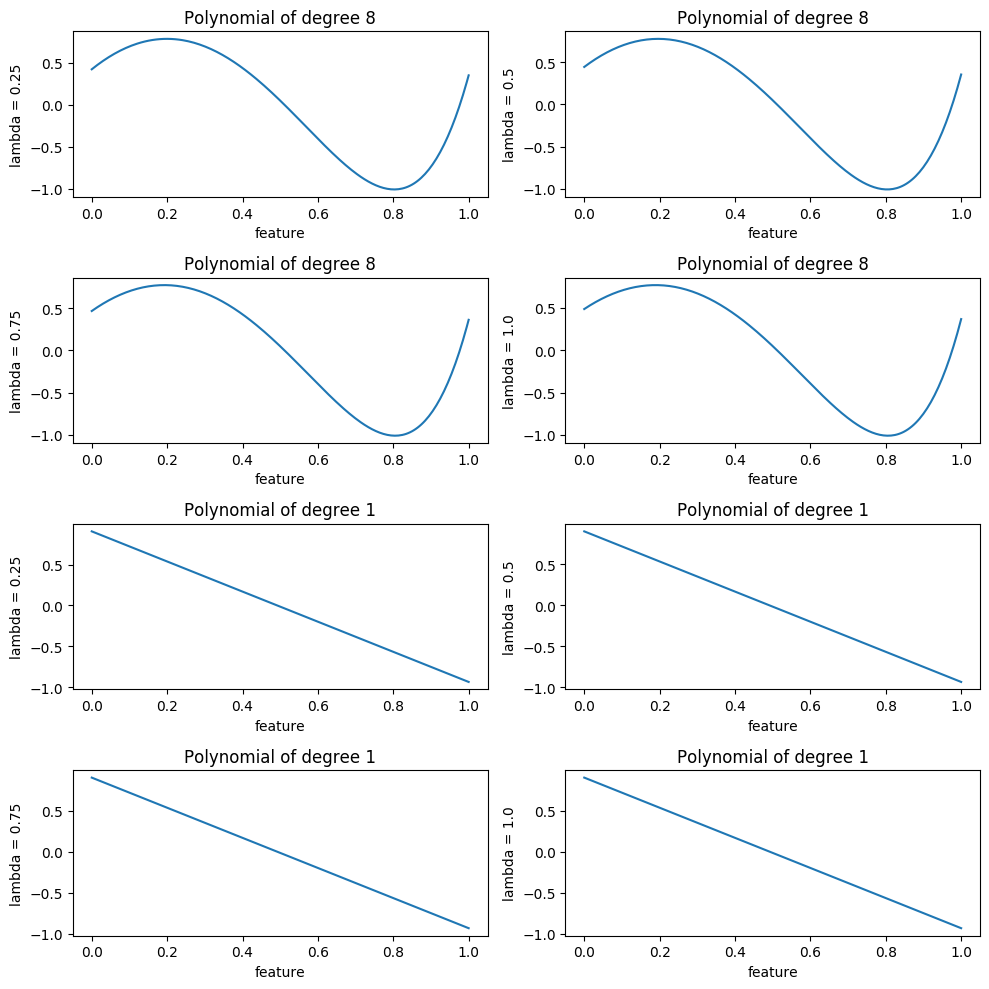

In [621]:
fig, axes = plt.subplots(nrows=4, ncols=2,figsize=(10,10),dpi=100)

for i in range(0,8):
    axes[int(i/2),i%2].plot(x_plot, y_plot[:,i:i+1])
    axes[int(i/2),i%2].set_xlabel('feature')
    axes[int(i/2),i%2].set_ylabel(f"lambda = {lambdas[i%4]}")
    axes[int(i/2),i%2].set_title(f'Polynomial of degree {8 if i<4 else 1}')            
    

fig
plt.tight_layout()

### Ridge Regression

In [622]:
train=pd.read_csv("train.csv")
train.columns=['x','y']
feature=train['x']
outputs=train[['y']]
y=outputs.to_numpy()
y=y.reshape(y.size,1)
x=feature.to_numpy()
x=x.reshape(x.size,1)

train.drop('y',axis=1,inplace=True)
for i in range(2,10):
    train[f'x{i}']=train['x']**i
train.insert(loc=0,column='x0',value=1)
train.rename(columns={'x':'x1'},inplace=True)
factor=(((train**2).sum(axis=0))/1000)**.5
train=train/factor

In [623]:
param3=np.zeros((9,4))
for i in range(4):
    lam=lambdas[i]
    alpha=.05
    prev_error=float("inf")
    theta=np.zeros(9)
    theta.resize((9,1))
    m=x.shape[0]
    while(True):
        h_theta=np.matmul(train.to_numpy()[:,:9],theta)
        errors=h_theta-outputs.to_numpy()
        curr_error=np.sum(errors**2)/(2*m)
        #print("curr_error is ")
        #print(curr_error)
        if(prev_error-curr_error<.0000001):
            break
        prev_error=curr_error
        partial=theta*alpha*lam/m+(alpha/m)*np.matmul(train.to_numpy()[:,:9].transpose(),errors)
        partial[0]=partial[0]-theta[0]*alpha*lam/m
        theta=theta-partial
    param3[:,i:i+1]=theta


In [624]:
param4=np.zeros((2,4))
for i in range(4):
    lam=lambdas[i]
    alpha=.05
    prev_error=float("inf")
    theta=np.zeros(2)
    theta.resize((2,1))
    m=x.shape[0]
    while(True):
        h_theta=np.matmul(train.to_numpy()[:,:2],theta)
        errors=h_theta-outputs.to_numpy()
        curr_error=np.sum(errors**2)/(2*m)
        #print("curr_error is ")
        #print(curr_error)
        if(prev_error-curr_error<.0000001):
            break
        prev_error=curr_error
        partial=theta*alpha*lam/m+(alpha/m)*np.matmul(train.to_numpy()[:,:2].transpose(),errors)
        partial[0]=partial[0]-theta[0]*alpha*lam/m
        theta=theta-partial
    param4[:,i:i+1]=theta

In [625]:
param3

array([[ 0.24498406,  0.33788118,  0.40294826,  0.45046902],
       [ 2.96321101,  2.38529681,  1.98532718,  1.69710482],
       [-4.16990992, -3.44291552, -2.94705874, -2.595694  ],
       [-2.65877665, -2.29331079, -2.03981471, -1.8569409 ],
       [ 0.34841695,  0.12967144, -0.01523786, -0.11445874],
       [ 2.08583181,  1.58832693,  1.25064379,  1.0130636 ],
       [ 2.1089859 ,  1.70070055,  1.4209183 ,  1.222148  ],
       [ 0.70146247,  0.67519614,  0.6544436 ,  0.63762435],
       [-1.72091444, -1.16639554, -0.79025519, -0.52625332]])

In [626]:
param4

array([[ 0.9112749 ,  0.91073625,  0.91021285,  0.90962264],
       [-1.10903651, -1.10834969, -1.10767829, -1.10694029]])

In [627]:
def process(x,n):
    x=x.copy()
    #print(x)
    for i in range(2,n):
        x[f'x{i}']=x['x']**i
        #print(x.head)
    x.insert(loc=0,column='x0',value=1)
    #print(x)
    x.rename(columns={'x':'x1'},inplace=True)
    x=x/factor.iloc[:n]
    #print(x)
    return x

x_plot=np.linspace(0,1,200);
x_plot=pd.DataFrame(data=x_plot,columns=['x'])
y_plot=np.zeros((x_plot.shape[0],2*param1.shape[1]))
x_processed=process(x_plot,10)
y_plot[:,:4]=x_processed.iloc[:,:-1]@param3
y_plot[:,4:]=x_processed.iloc[:,:2]@param4

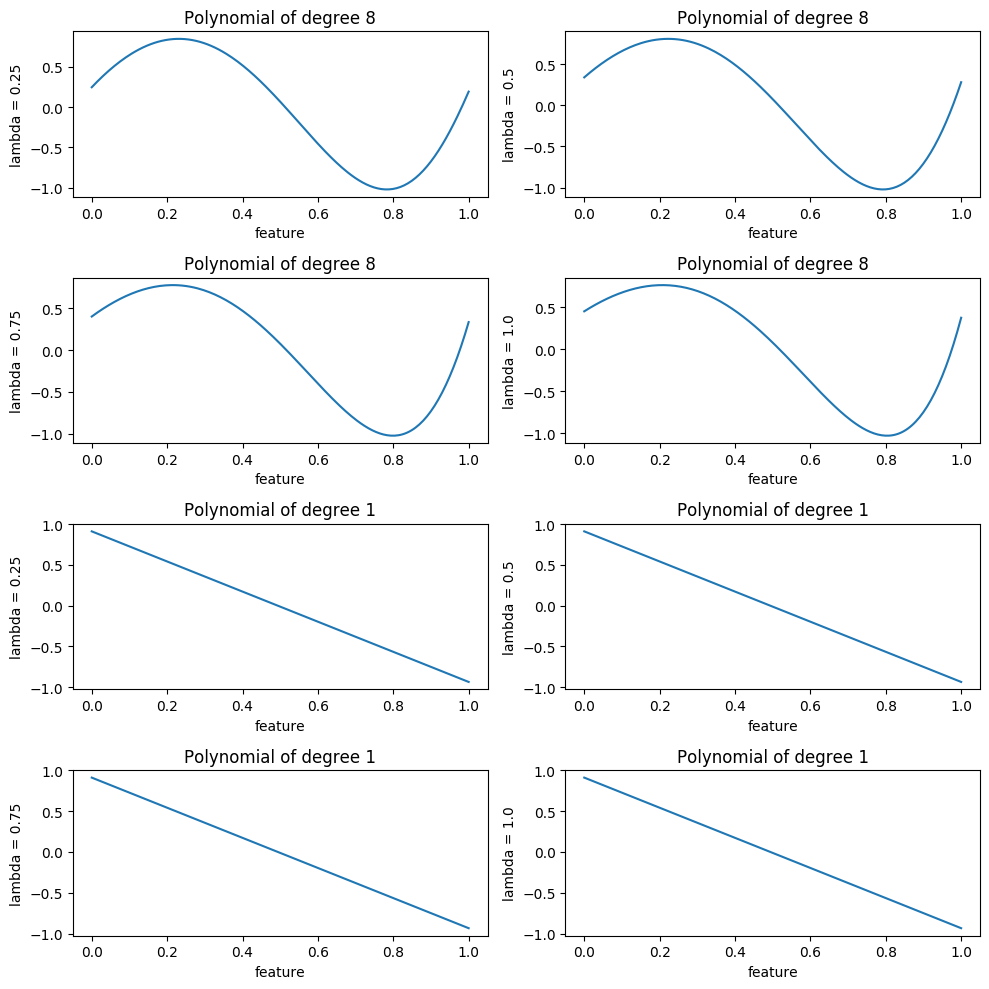

In [628]:
fig, axes = plt.subplots(nrows=4, ncols=2,figsize=(10,10),dpi=100)

for i in range(0,8):
    axes[int(i/2),i%2].plot(x_plot, y_plot[:,i:i+1])
    axes[int(i/2),i%2].set_xlabel('feature')
    axes[int(i/2),i%2].set_ylabel(f"lambda = {lambdas[i%4]}")
    axes[int(i/2),i%2].set_title(f'Polynomial of degree {8 if i<4 else 1}')            
    

fig
plt.tight_layout()

Train Error

In [629]:
errors_ridge=np.zeros((param1.shape[1],4))
errors_ridge[:,0]=find_error(param3,train.iloc[:,:param3.shape[0]],outputs)
errors_ridge[:,1]=find_error(param4,train.iloc[:,:param4.shape[0]],outputs)

Test Error

In [630]:
errors_ridge[:,2]=find_error(param3,test.iloc[:,:param3.shape[0]],outputs_test)
errors_ridge[:,3]=find_error(param4,test.iloc[:,:param4.shape[0]],outputs_test)

## Plotting test and training errors of Lasso and Ridge Regression

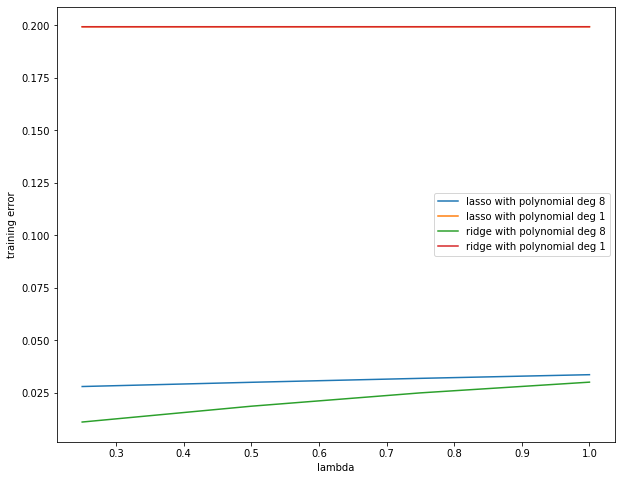

In [631]:
fig1,ax1=plt.subplots(figsize=(10,8))
ax1.set_xlabel('lambda')
ax1.set_ylabel('training error')
ax1.plot(lambdas,errors_lasso[:,0],label="lasso with polynomial deg 8")
ax1.plot(lambdas,errors_lasso[:,1],label="lasso with polynomial deg 1")
ax1.plot(lambdas,errors_ridge[:,0],label="ridge with polynomial deg 8")
ax1.plot(lambdas,errors_ridge[:,1],label="ridge with polynomial deg 1")
ax1.legend()

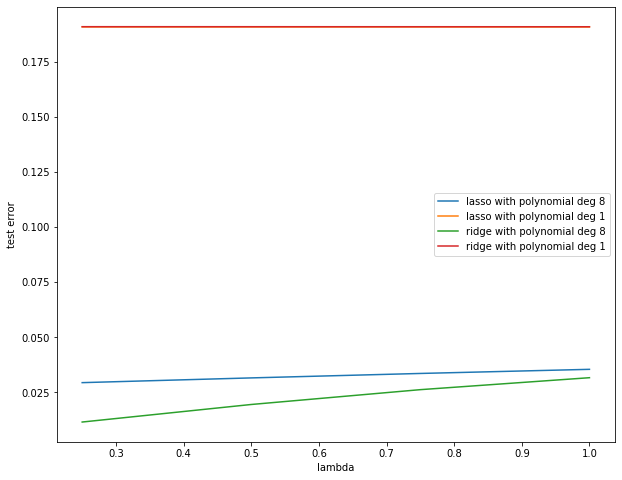

In [632]:
fig2,ax2=plt.subplots(figsize=(10,8))
ax2.set_xlabel('lambda')
ax2.set_ylabel('test error')
ax2.plot(lambdas,errors_lasso[:,2],label="lasso with polynomial deg 8")
ax2.plot(lambdas,errors_lasso[:,3],label="lasso with polynomial deg 1")
ax2.plot(lambdas,errors_ridge[:,2],label="ridge with polynomial deg 8")
ax2.plot(lambdas,errors_ridge[:,3],label="ridge with polynomial deg 1")
ax2.legend()

What differences do you notice between the two kind`s of regression? 

I noticed that in Lasso regression parameters for which the output is not strongly related to the corrosponding features are set to exactly 0 whereas in Ridge regression parameters are never set exactly to zero. Hence Lasso Regression may help us in selecting proper relavent features. 
Both lasso and ridge helps in reducing the model complexity and coefficient shrinkage. 

Which one would you prefer for this problem and why?

I would prefer Ridge regression as I don't think we need help in selecting the proper features for the given dataset. We can easily take a sinusoidal feature which would perfectly fit the given dataset. Also, mean square error of ridge regression model is lower on both training and test dataset as compared to lasso regression model for all values of lambda. Thus Ridge regression model would be better for this case 